
# [YOLOR: You Only Learn One Representation](https://arxiv.org/abs/2105.04206)

YOLOR is the latest State-Of-the-Art Object Detection Model that is better and faster than YOLOv4, Scaled YOLOv4, YOLOv5 and PP-YOLOv2!

<p><br>

<div>
<img src="./Sources/1.png" width="400" height="200"/>
</div>

<p><br>
    

## How to Train YOLOR on Fruits Objects

This is using the [YOLOR repository](https://github.com/WongKinYiu/yolor) by [Wong Kin-Yiu](https://github.com/WongKinYiu). 

Steps to train fruit detector:
* Step-1: Read and Refine Data to yolo format and prepare required files
* Step-2: Install YOLOR (Clone and Install YOLOR dependencies, Prepare Pre-Trained Weights)
* Step-3: Training

# Change Runtime and check it to be GPU

In [1]:
import torch
print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


# Connent to google drive


In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step-1: Read and Convert Data to yolo format




## UnZip Data

In [5]:
# !unzip '/content/drive/MyDrive/Fruits/test_zip_new.zip' 
# !unzip '/content/drive/MyDrive/Fruits/train_zip_new.zip' 

##Conver to yolo format

In [32]:

import glob
from numpy import expand_dims
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
import cv2
import matplotlib.pyplot as plt
import glob
from shutil import copy

def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.jpg'):
        image_list.append(filename)

    return image_list

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path_label,output_path_image, image_path):
    img = {'object':[]}
    img['filename'] = image_path
    basename = os.path.basename(image_path)
    copy(image_path,output_path_image) 
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path_label + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    img['width'] = w
    h = int(size.find('height').text)
    img['height'] = h
    objs = {}
    flag=False
    for obj in root.iter('object'):    
        difficult = obj.find('difficult').text
        cls = obj.find('name').text

        if cls not in classes or int(difficult)==1:
            continue
        objs['name'] = cls
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        xmin,xmax,ymin,ymax = float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text)
        b = (xmin,xmax,ymin,ymax)
        objs['xmin'],objs['xmax'],objs['ymin'],objs['ymax'] = xmin,xmax,ymin,ymax
        if w==0 or h==0:
            flag=False
        else:
            bb = convert((w,h), b)
            img['object'] += [objs]
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) +str(cls_id)+ '\n')
            flag=True

    return img,flag



classes = ['apple','banana','orange','pineapple','strawberry','mango']  

dirs = ['train','test']
train_image_folder = "/content/train"
test_image_folder = "/content/test"


   
def process_annotation(name):
    all_imgs  =  []
    full_dir_path='/content/'+name+'_zip/'+name+'/'
    output_path_label= '/content/Fruits/labels/'+name+'/'
    output_path_image= '/content/Fruits/images/'+name

    if not os.path.exists(output_path_label):
        os.makedirs(output_path_label)
    if not os.path.exists(output_path_image):
        os.makedirs(output_path_image)

    image_paths = getImagesInDir(full_dir_path)
    list_file = open('/content/Fruits/' + name+'.txt', 'w')
    print(len(image_paths))
    for image_path in image_paths:
        
        img,flag=convert_annotation(full_dir_path, output_path_label,output_path_image, image_path)
        if flag == False:
            continue
        else:
              # for objs in img['object']:
              #   list_file.write(image_path+ ", "+ ", ".join([str(a) for a in [objs['xmin'],objs['ymin'],objs['xmax'],objs['ymax'],objs['name']]])+'\n')
              list_file.write(image_path+'\n')
              all_imgs += [img]
    list_file.close()

    print("Finished processing: " + full_dir_path)
    return all_imgs

all_imgs_train = process_annotation('train')
all_imgs_test = process_annotation('test')  

290
Finished processing: /content/train_zip/train/
66
Finished processing: /content/test_zip/test/


In [ ]:
all_imgs_train[180]

{'filename': '/content/train_zip/train/banana_70.jpg',
 'height': 900,
 'object': [{'name': 'banana',
   'xmax': 1590.0,
   'xmin': 17.0,
   'ymax': 624.0,
   'ymin': 1.0}],
 'width': 1940}

In [6]:
len(all_imgs_train)

0

## Remove extra files

In [35]:
# to remove a whole of a directory
os.system("rm -rf /content/train_zip/")
os.system("rm -rf /content/test_zip/")

0

In [ ]:
!ls

drive  Fruits  sample_data  test_zip  train_zip


## Create Fruits-data.yaml file for training



In [7]:
fruitData_Dir = '/content/drive/MyDrive/Fruits/Fruits-data.yaml'

In [9]:
from IPython.core.magic import register_line_cell_magic
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/Fruits-data.yaml

path: ../Fruits/images
train: ../Fruits/images/train  #
val: ../Fruits/images/train   # 
test: ../Fruits/images/test # 
nc: 6
# class names
names: ['apple','banana','orange','pineapple','strawberry','mango'] 

In [11]:
%cat /content/Fruits-data.yaml


path: ../Fruits/images
train: ../Fruits/images/train  #
val: ../Fruits/images/train   # 
test: ../Fruits/images/test # 
nc: 6
# class names
names: ['apple','banana','orange','pineapple','strawberry','mango'] 

## Create Fruits.names file for testing and detecting

In [23]:
# Create names file for model
import yaml
import ast
with open(fruitData_Dir, 'r') as stream:
    names = str(yaml.safe_load(stream)['names'])

namesFile = open("../Fruits.names", "w+")
names = ast.literal_eval(names)
for name in names:
  namesFile.write(name +'\n')
namesFile.close()

In [71]:
%cat /content/Fruits.names

apple
banana
orange
pineapple
strawberry
mango


# Step-2: Install YOLOR

## Clone the repository
This is PyTorch implementation of YOLOv4 which is based on ultralytics/yolov5 (availabel in u5 bramch).

In [14]:
!git clone https://github.com/WongKinYiu/yolor

Cloning into 'yolor'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 371 (delta 102), reused 51 (delta 46), pack-reused 210
Receiving objects: 100% (371/371), 2.97 MiB | 7.50 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [15]:
cd /content/yolor

/content/yolor


In [16]:
!ls

cfg	 detect.py  LICENSE    requirements.txt  train.py
darknet  figure     models     scripts		 tune.py
data	 inference  README.md  test.py		 utils


## Install requirments

In [17]:
!pip install -qr requirements.txt

     |████████████████████████████████| 636 kB 8.5 MB/s 
     |████████████████████████████████| 776.7 MB 4.6 kB/s 
     |████████████████████████████████| 12.7 MB 91 kB/s 
     |████████████████████████████████| 1.5 MB 54.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.0 which is incompatible.


## Install Mish CUDA


In [18]:
!git clone https://github.com/JunnYu/mish-cuda
%cd mish-cuda
!git reset --hard 6f38976064cbcc4782f4212d7c0c5f6dd5e315a8
!python setup.py build install
%cd ..

Cloning into 'mish-cuda'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 195 (delta 7), reused 79 (delta 3), pack-reused 107
Receiving objects: 100% (195/195), 208.77 KiB | 1.81 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/yolor/mish-cuda
HEAD is now at 6f38976 Update README.md
/usr/lib/python3.7/distutils/extension.py:131: UserWarning: Unknown Extension options: 'headers'
  warnings.warn(msg)
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/mish_cuda
copying src/mish_cuda/__init__.py -> build/lib.linux-x86_64-3.7/mish_cuda
running egg_info
creating src/mish_cuda.egg-info
writing src/mish_cuda.egg-info/PKG-INFO
writing dependency_links to src/mish_cuda.egg-info/dependency_links.txt
writing requirements to src/mish_cuda.egg-info/requires.txt
writing top-level names to src/mish_cuda.egg-info/top_level.t

## Install PyTorch Wavelets


In [19]:
!git clone https://github.com/fbcotter/pytorch_wavelets
%cd pytorch_wavelets
!pip install .
%cd ..

Cloning into 'pytorch_wavelets'...
remote: Enumerating objects: 972, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 972 (delta 75), reused 89 (delta 45), pack-reused 836
Receiving objects: 100% (972/972), 6.80 MiB | 12.89 MiB/s, done.
Resolving deltas: 100% (659/659), done.
/content/yolor/pytorch_wavelets
Processing /content/yolor/pytorch_wavelets
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.3.0-py3-none-any.whl size=54869 sha256=56704ddac038ea4b68d6591b8746c96b557a5dba39a1ab80b5e3cdedc5c1fd75
  Stored in di

## Prepare Pre-Trained Weights for YOLOR

In [20]:
!bash scripts/get_pretrain.sh


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2358      0 --:--:-- --:--:-- --:--:--  2344
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  142M    0  142M    0     0  76.3M      0 --:--:--  0:00:01 --:--:--  132M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1102      0 --:--:-- --:--:-- --:--:--  1102
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  305M    0  305M    0     0  89.6M      0 --:--:--  0:00:03 --:--:--  123M


## Refine YOLOR Configuration

In [21]:
import yaml
with open(fruitData_Dir) as f:
    dataMap = yaml.safe_load(f)

num_classes = len(dataMap['names'])
num_filters = (num_classes + 5) * 3

In [22]:
%%writetemplate /content/yolor/cfg/yolor_p6.cfg

[net]
batch=64
subdivisions=8
width=1280
height=1280
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 500500
policy=steps
steps=400000,450000
scales=.1,.1

mosaic=1


# ============ Backbone ============ #

# Stem 

# P1

# Downsample

# 0
[reorg]

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=silu


# P2

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=silu

# Residual Block

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

# Transition first
#
#[convolutional]
#batch_normalize=1
#filters=64
#size=1
#stride=1
#pad=1
#activation=silu

# Merge [-1, -(3k+3)]

[route]
layers = -1,-12

# Transition last

# 16 (previous+6+3k)
[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu


# P3

# Downsample

[convolutional]
batch_normalize=1
filters=256
size=3
stride=2
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

# Residual Block

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

# Transition first
#
#[convolutional]
#batch_normalize=1
#filters=128
#size=1
#stride=1
#pad=1
#activation=silu

# Merge [-1, -(3k+3)]

[route]
layers = -1,-24

# Transition last

# 43 (previous+6+3k)
[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu


# P4

# Downsample

[convolutional]
batch_normalize=1
filters=384
size=3
stride=2
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

# Residual Block

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=192
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=192
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=192
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=192
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=192
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=192
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=192
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

# Transition first
#
#[convolutional]
#batch_normalize=1
#filters=192
#size=1
#stride=1
#pad=1
#activation=silu

# Merge [-1, -(3k+3)]

[route]
layers = -1,-24

# Transition last

# 70 (previous+6+3k)
[convolutional]
batch_normalize=1
filters=384
size=1
stride=1
pad=1
activation=silu


# P5

# Downsample

[convolutional]
batch_normalize=1
filters=512
size=3
stride=2
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

# Residual Block

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

# Transition first
#
#[convolutional]
#batch_normalize=1
#filters=256
#size=1
#stride=1
#pad=1
#activation=silu

# Merge [-1, -(3k+3)]

[route]
layers = -1,-12

# Transition last

# 85 (previous+6+3k)
[convolutional]
batch_normalize=1
filters=512
size=1
stride=1
pad=1
activation=silu


# P6

# Downsample

[convolutional]
batch_normalize=1
filters=640
size=3
stride=2
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

# Residual Block

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=320
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=320
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=320
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

# Transition first
#
#[convolutional]
#batch_normalize=1
#filters=320
#size=1
#stride=1
#pad=1
#activation=silu

# Merge [-1, -(3k+3)]

[route]
layers = -1,-12

# Transition last

# 100 (previous+6+3k)
[convolutional]
batch_normalize=1
filters=640
size=1
stride=1
pad=1
activation=silu

# ============ End of Backbone ============ #

# ============ Neck ============ #

# CSPSPP

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=320
activation=silu

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

### SPP ###
[maxpool]
stride=1
size=5

[route]
layers=-2

[maxpool]
stride=1
size=9

[route]
layers=-4

[maxpool]
stride=1
size=13

[route]
layers=-1,-3,-5,-6
### End SPP ###

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=320
activation=silu

[route]
layers = -1, -13

# 115 (previous+6+5+2k)
[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

# End of CSPSPP


# FPN-5

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[upsample]
stride=2

[route]
layers = 85

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[route]
layers = -1, -3

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

# Plain Block

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=silu

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=silu

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=silu

# Merge [-1, -(2k+2)]

[route]
layers = -1, -8

# Transition last

# 131 (previous+6+4+2k)
[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu


# FPN-4

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[upsample]
stride=2

[route]
layers = 70

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[route]
layers = -1, -3

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

# Plain Block

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=192
activation=silu

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=192
activation=silu

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=192
activation=silu

# Merge [-1, -(2k+2)]

[route]
layers = -1, -8

# Transition last

# 147 (previous+6+4+2k)
[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu


# FPN-3

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[upsample]
stride=2

[route]
layers = 43

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[route]
layers = -1, -3

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

# Plain Block

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=128
activation=silu

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=128
activation=silu

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=128
activation=silu

# Merge [-1, -(2k+2)]

[route]
layers = -1, -8

# Transition last

# 163 (previous+6+4+2k)
[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=silu


# PAN-4

[convolutional]
batch_normalize=1
size=3
stride=2
pad=1
filters=192
activation=silu

[route]
layers = -1, 147

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

# Plain Block

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=192
activation=silu

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=192
activation=silu

[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=192
activation=silu

[route]
layers = -1,-8

# Transition last

# 176 (previous+3+4+2k)
[convolutional]
batch_normalize=1
filters=192
size=1
stride=1
pad=1
activation=silu


# PAN-5

[convolutional]
batch_normalize=1
size=3
stride=2
pad=1
filters=256
activation=silu

[route]
layers = -1, 131

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

# Plain Block

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=silu

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=silu

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=silu

[route]
layers = -1,-8

# Transition last

# 189 (previous+3+4+2k)
[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=silu


# PAN-6

[convolutional]
batch_normalize=1
size=3
stride=2
pad=1
filters=320
activation=silu

[route]
layers = -1, 115

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

# Plain Block

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=320
activation=silu

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=320
activation=silu

[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=320
activation=silu

[route]
layers = -1,-8

# Transition last

# 202 (previous+3+4+2k)
[convolutional]
batch_normalize=1
filters=320
size=1
stride=1
pad=1
activation=silu

# ============ End of Neck ============ #

# 203
[implicit_add]
filters=256

# 204
[implicit_add]
filters=384

# 205
[implicit_add]
filters=512

# 206
[implicit_add]
filters=640

# 207
[implicit_mul]
filters={num_filters}

# 208
[implicit_mul]
filters={num_filters}

# 209
[implicit_mul]
filters={num_filters}

# 210
[implicit_mul]
filters={num_filters}

# ============ Head ============ #

# YOLO-3

[route]
layers = 163

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=256
activation=silu

[shift_channels]
from=203

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear

[control_channels]
from=207

[yolo]
mask = 0,1,2
anchors = 19,27,  44,40,  38,94,  96,68,  86,152,  180,137,  140,301,  303,264,  238,542,  436,615,  739,380,  925,792
classes={num_classes}
num=12
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1
scale_x_y = 1.05
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6


# YOLO-4

[route]
layers = 176

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=384
activation=silu

[shift_channels]
from=204

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear

[control_channels]
from=208

[yolo]
mask = 3,4,5
anchors = 19,27,  44,40,  38,94,  96,68,  86,152,  180,137,  140,301,  303,264,  238,542,  436,615,  739,380,  925,792
classes={num_classes}
num=12
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1
scale_x_y = 1.05
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6


# YOLO-5

[route]
layers = 189

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=512
activation=silu

[shift_channels]
from=205

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear

[control_channels]
from=209

[yolo]
mask = 6,7,8
anchors = 19,27,  44,40,  38,94,  96,68,  86,152,  180,137,  140,301,  303,264,  238,542,  436,615,  739,380,  925,792
classes={num_classes}
num=12
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1
scale_x_y = 1.05
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6


# YOLO-6

[route]
layers = 202

[convolutional]
batch_normalize=1
size=3
stride=1
pad=1
filters=640
activation=silu

[shift_channels]
from=206

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear

[control_channels]
from=210

[yolo]
mask = 9,10,11
anchors = 19,27,  44,40,  38,94,  96,68,  86,152,  180,137,  140,301,  303,264,  238,542,  436,615,  739,380,  925,792
classes={num_classes}
num=12
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1
scale_x_y = 1.05
iou_thresh=0.213
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
nms_kind=greedynms
beta_nms=0.6

# ============ End of Head ============ #

In [ ]:
%cat /content/yolor/cfg/yolor_p6.cfg


[net]
batch=64
subdivisions=8
width=1280
height=1280
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 500500
policy=steps
steps=400000,450000
scales=.1,.1

mosaic=1


# ============ Backbone ============ #

# Stem 

# P1

# Downsample

# 0
[reorg]

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=silu


# P2

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=silu

# Residual Block

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1

# Step-3: Training and Detecting


## Fine-Tuning

In [96]:
!python train.py --epochs 300 --batch-size 16 --img 640 640 --data /content/Fruits-data.yaml --cfg cfg/yolor_p6.cfg --weights /content/yolor/yolor_p6.pt --device 0 --name YOLOR_Fruit --hyp '/content/yolor/data/hyp.scratch.1280.yaml' 


## Export Trained Model to Google Drive

In [37]:
%cp runs/train/YOLOR_Fruit/weights/best.pt /content/drive/My\ Drive/Fruits

# import torch
# MODEL_PATH = '/content/yolov5/runs/train/exp/weights/best.pt'
# model = torch.load(MODEL_PATH)

## Plot results

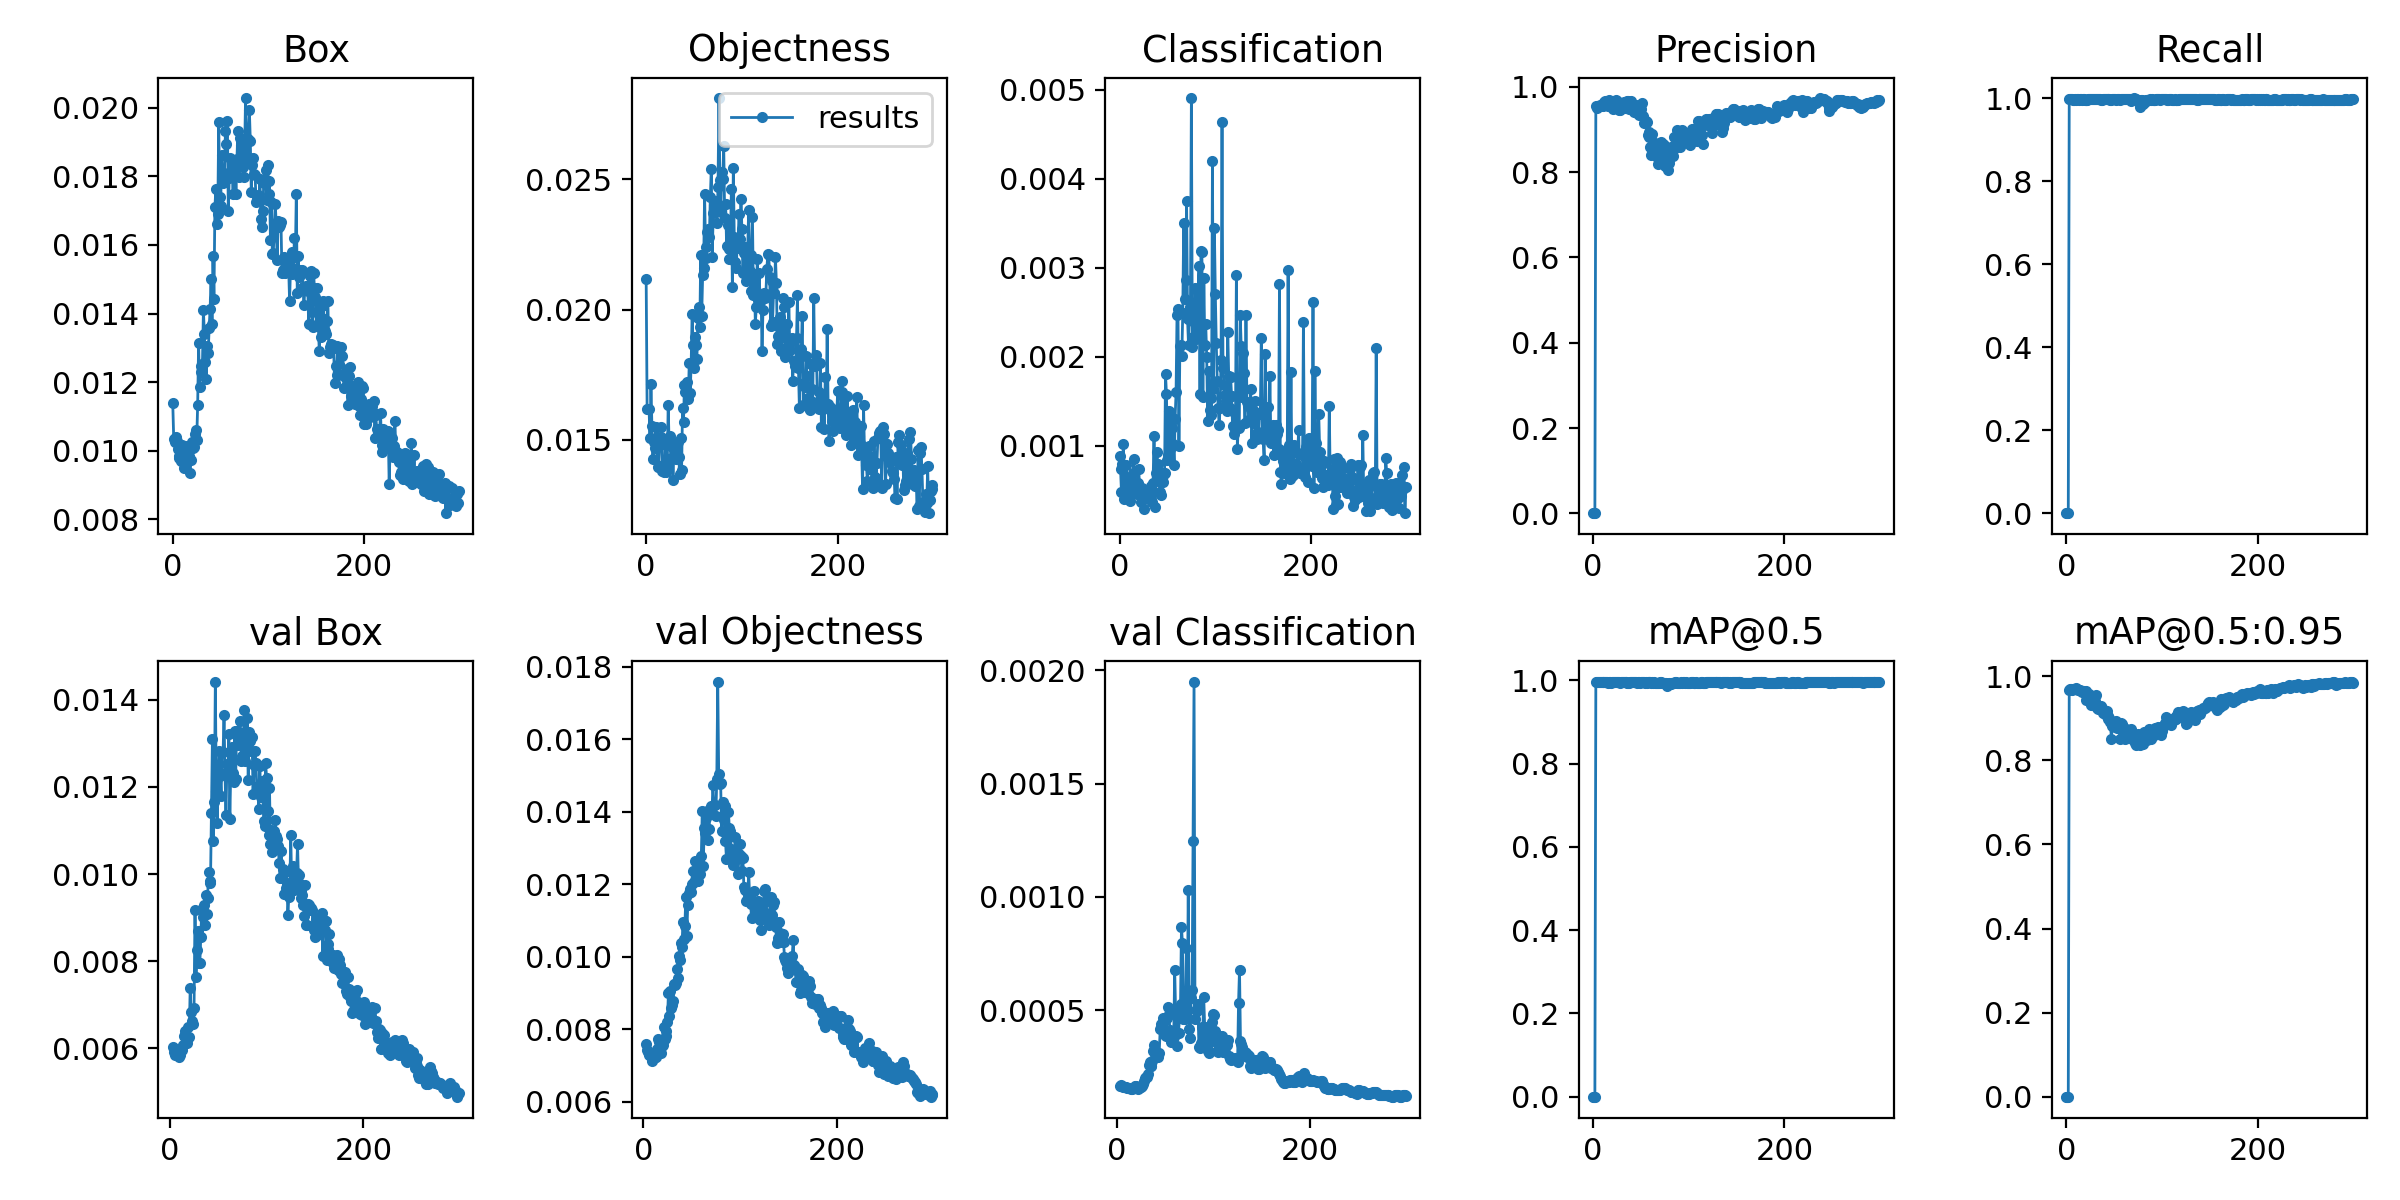

In [38]:
from IPython.display import Image
Image(filename='/content/yolor/runs/train/YOLOR_Fruit/results.png', width=800)

##Show results of test batches

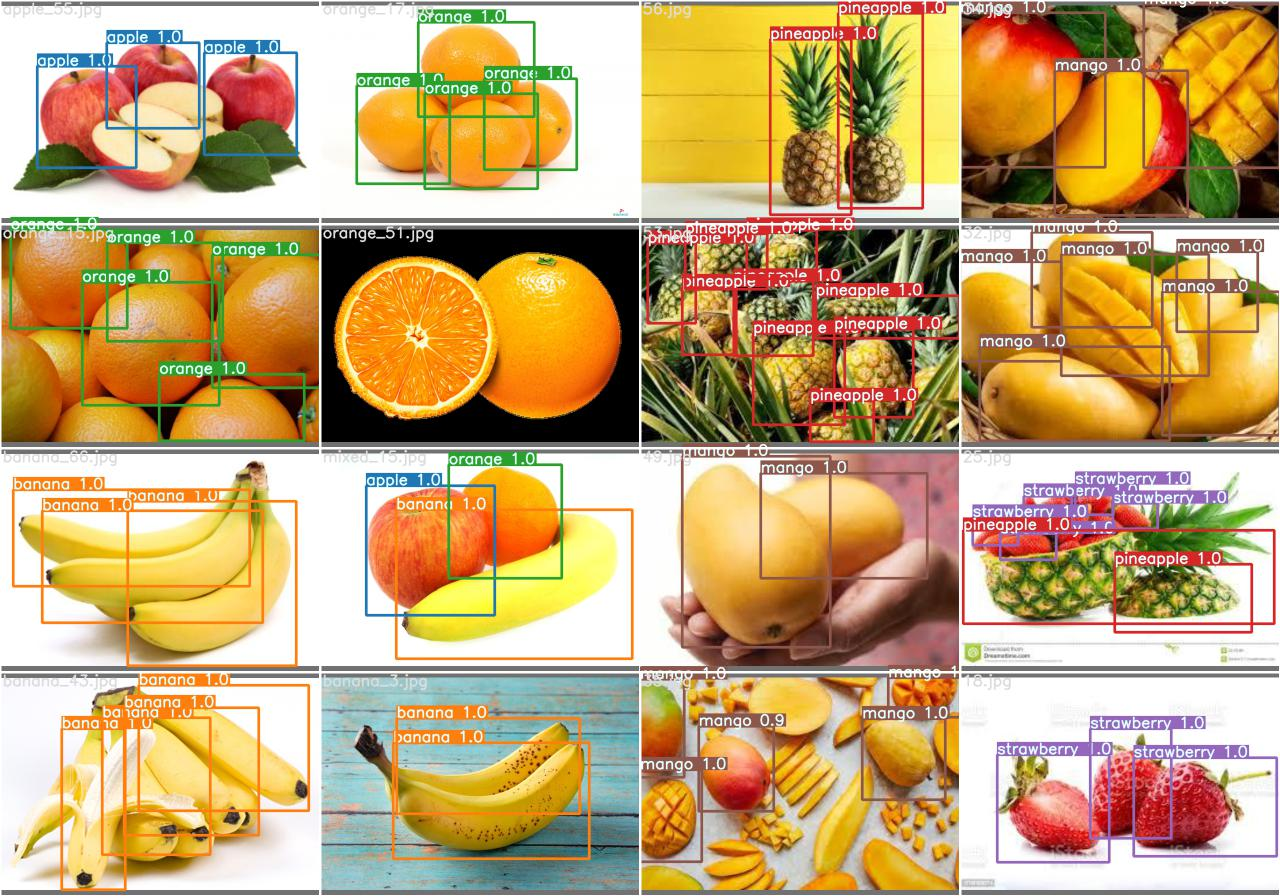

In [39]:
from IPython.display import Image
Image(filename='/content/yolor/runs/train/YOLOR_Fruit/test_batch2_pred.jpg') 


## Detect results on one test images

In [109]:
!python detect.py  --source /content/113.jpg --weights /content/yolor/runs/train/YOLOR_Fruit/weights/best.pt --conf 0.7 --iou 0.5 --img-size 640 --names /content/Fruits.names


Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolor_p6.cfg', classes=None, conf_thres=0.7, device='', img_size=640, iou_thres=0.5, names='/content/Fruits.names', output='inference/output', save_txt=False, source='/content/113.jpg', update=False, view_img=False, weights=['/content/yolor/runs/train/YOLOR_Fruit/weights/best.pt'])
image 1/1 /content/113.jpg: 512x640 2 apples, 1 bananas, 1 oranges, 1 strawberrys, 1 mangos, Done. (0.028s)
Results saved to inference/output
Done. (0.084s)


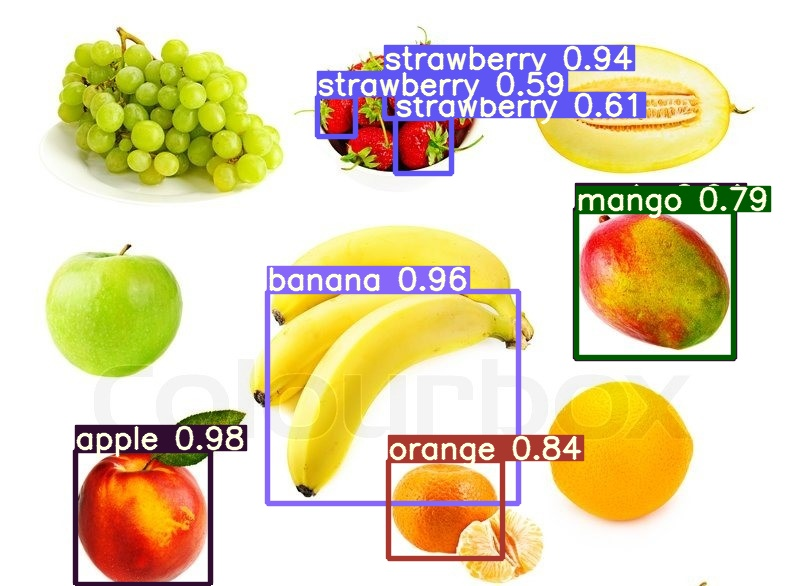

In [108]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolor/inference/output/*.jpg'): #assuming JPG
    display(Image(filename=imageName,width=800))
    print("\n")

## Detect objects on webcam

In [42]:
# !python detect.py --source 0 --cfg cfg/yolor_p6.cfg --weights /content/yolor/runs/train/yolor_p68/weights/best.pt --conf 0.25 --img-size 640 --device 0